In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load Dataset + fix messed up column headers
df = pd.read_csv('winequality-red-5.csv', delimiter=';', engine='python')
cols = df.columns[0]
cleaned_cols = [col.strip().strip('"') for col in cols.split(';')]

df = pd.read_csv('winequality-red-5.csv', delimiter=';', skiprows=1, header=None)
df.columns = cleaned_cols
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Preprocesssing

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('quality', axis=1)
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, # Preserve distribution of y within groups
    random_state=42
)

scaler = StandardScaler() # Remove mean, scale to unit variance
# fit scalar on training data + apply to both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ANN Model

Main hyper-params to consider:
- num nodes and num nodes/layer
- regularization value --> MLPClassifier only supports L2 (alpha)
- learning rate
- early stopping
- batch size

In [3]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(100,), # one hidden layer w 100 neurons
    activation='relu', # non-linear
    solver='adam', # optomizer for updating weights
    alpha=0.0001,
    max_iter=300,
    n_iter_no_change=20,
    early_stopping=True, # automatically uses a validation split to determine if early stop encessary
    random_state=42
)

# Fit on training data
mlp.fit(X_train_scaled, y_train)

MLPClassifier(early_stopping=True, max_iter=300, n_iter_no_change=20,
              random_state=42)

- Precision: % of predicted positives that ARE positive
- Recall: % of actual positives that WERE predicted as positive
- F1-score: Harmonic mean of precision and recall. 1 is perfect, 0 is bad.
    --> 0.6-0.7 is lowest acceptable, below that is weak
- Support: Number of true instances for each class in y_test.

- accuracy = correct pred / total pred
- macro avg = avg precision/recal/f-1 (respectively) over all classes. i.e the avgprecision is 0.29.
- weighted avg = like macro avg but takes into account # instances for each class --> helpful for imbalanced classes

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = mlp.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.59      0.80      0.68       136
           6       0.54      0.48      0.51       128
           7       0.59      0.33      0.42        40
           8       0.00      0.00      0.00         3

    accuracy                           0.57       320
   macro avg       0.29      0.27      0.27       320
weighted avg       0.54      0.57      0.55       320



Interpretation: 
- 57% of all preds were correct
- 3,4,8 had 0 correct classifications --> model biased to majority classes
- Class 5 has highest support AND best performance --> indicates bias to support
- Class 6 has pretty balanced precision/recal
- class 7 had poor recall, meaning it MISSED many of its instances

- weighted averages ~ double macro averages means bias to suppport. Accounting for weight gives better performance so higher weighted classes do better.

In [5]:
print("Pred      3    4    5    6    7    8")
confusion_matrix(y_test, y_pred)

Pred      3    4    5    6    7    8


array([[  0,   0,   1,   1,   0,   0],
       [  0,   0,  11,   0,   0,   0],
       [  0,   0, 109,  25,   2,   0],
       [  0,   0,  60,  62,   6,   0],
       [  0,   0,   3,  24,  13,   0],
       [  0,   0,   0,   2,   1,   0]])

- Rows correspond to true class
- columns correspond to predicted class
- values on the main diagonal show correct predictons for each class
- values OFF diagonal show missclassifications
- Tells you which classes were missclassified as what

Observations:
- class 3 (2 total obs.) fully missclassified as one 5 and one 6
- class 4 entirely missclassified as 5
- class 5 had allmost all missclassifications (25/27) as class 6
- class 6 had majority missclassifications (60/66) as class 5
- class 7 had majority of missclassifications (24/27) as class 6
- class 8 (2 total obs.) full missclassified as one 7 and two 6

Interpretation:
- Seems to be an ordinal relationship between classes
- most missclassifications are as 5 or 6 because they dominate training of model

Grid search for optomizing:
- hidden layer sizes (both nodes and nodes/layer)
- alpha
- learning rate

Method for Grid Search:
1) run a coarse grid covering a broad range of architectures to find best architecture
3) Fine tune around the best architecture to find the optimal combo in that area
4) once you know  the region, switch to randomized search to sample more surrounding combos
5) pick the simplest model that is close enough to best accuracy

## Course Grid

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    'hidden_layer_sizes': [
        (50,),       # one small layer
        (100,),      # one medium layer
        (150,),      # one large layer
        (100, 50),   # two layers, tapered
        (150, 75),   # two larger layers, also tapered
        (200, 100),   # two layers, wider
        (100, 50, 25),# three layers, tapered
    ],
    'alpha': [1e-5, 1e-4, 1e-3],
    'learning_rate_init': [1e-4, 1e-3, 1e-2], 
}

grid = GridSearchCV(
    estimator=MLPClassifier(
        max_iter=500,
        early_stopping=True,
        random_state=42,
        solver="adam"
    ),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

course_grid_model = grid.best_estimator_
y_pred_course = course_grid_model.predict(X_test_scaled)
print("Test accuracy:", accuracy_score(y_test, y_pred_course))
print(classification_report(y_test, y_pred_course))
print("Macro-F1:", f1_score(y_test, y_pred_course, average='macro'))

Best params: {'alpha': 1e-05, 'hidden_layer_sizes': (150, 75), 'learning_rate_init': 0.01}
Best CV accuracy: 0.6090533088235295
Test accuracy: 0.60625
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.54      0.62       136
           6       0.55      0.75      0.63       128
           7       0.60      0.60      0.60        40
           8       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.31      0.32      0.31       320
weighted avg       0.61      0.61      0.59       320

Macro-F1: 0.30968932336271604


 ## Fine Grid

In [7]:
param_grid_fine = {
    # stick with mostly two layers, but try other combos
    'hidden_layer_sizes': [
        (150, 75), # current best
        (175, 90), # smaller
        (125, 60),      # evensmaller
        (150, 75, 30),  # medium size third layer
        (100, 50), # baseline two layer
    ],
    # surrounding alphas
    'alpha': [1e-6, 5e-6, 1e-5, 5e-5],
    # surrounding lr
    'learning_rate_init': [0.005, 0.01, 0.02]
}

fine_grid = GridSearchCV(
    estimator=MLPClassifier(
        max_iter=500,
        early_stopping=True,
        random_state=42,
    ),
    param_grid=param_grid_fine,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

fine_grid.fit(X_train_scaled, y_train)

print("Best params:", fine_grid.best_params_)
print("Best CV accuracy:", fine_grid.best_score_)


fine_grid_model = fine_grid.best_estimator_
y_pred_fine = fine_grid_model.predict(X_test_scaled)


print("Fine-grid MLP", fine_grid.best_params_)
print("Test accuracy:", accuracy_score(y_test, y_pred_fine))
print(classification_report(y_test, y_pred_fine))
print("Macro-F1:", f1_score(y_test, y_pred_fine, average='macro'))

Best params: {'alpha': 5e-05, 'hidden_layer_sizes': (125, 60), 'learning_rate_init': 0.02}
Best CV accuracy: 0.61453125
Fine-grid MLP {'alpha': 5e-05, 'hidden_layer_sizes': (125, 60), 'learning_rate_init': 0.02}
Test accuracy: 0.609375
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.70      0.64      0.67       136
           6       0.54      0.77      0.64       128
           7       0.75      0.23      0.35        40
           8       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.33      0.27      0.27       320
weighted avg       0.61      0.61      0.58       320

Macro-F1: 0.2749127435622612


## Random Search

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {
    # keep two layer
    'hidden_layer_sizes': [
        (125, 60), # current best
        (150, 75),    
        (100, 50), 
        (125, 60, 30),
        (150, 60),  
    ],
    'alpha': loguniform(1e-6, 1e-4),
    'learning_rate_init': loguniform(1e-3, 5e-2)
}

rs = RandomizedSearchCV(
    estimator=MLPClassifier(
        solver='adam',
        max_iter=500,
        early_stopping=True,
        random_state=42,
    ),
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train_scaled, y_train)

print("Best params:", rs.best_params_)
print("Best CV accuracy:", rs.best_score_)

random_search_model = rs.best_estimator_
y_pred_rs = random_search_model.predict(X_test_scaled)

print("Random-search MLP", rs.best_params_)
print("Test accuracy:", accuracy_score(y_test, y_pred_rs))
print(classification_report(y_test, y_pred_rs))
print("Macro-F1:", f1_score(y_test, y_pred_rs, average='macro'))

Best params: {'alpha': 1.4732618059500207e-06, 'hidden_layer_sizes': (125, 60, 30), 'learning_rate_init': 0.03362146348225422}
Best CV accuracy: 0.6145465686274509
Random-search MLP {'alpha': 1.4732618059500207e-06, 'hidden_layer_sizes': (125, 60, 30), 'learning_rate_init': 0.03362146348225422}
Test accuracy: 0.60625
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.66      0.70      0.68       136
           6       0.54      0.66      0.60       128
           7       0.74      0.35      0.47        40
           8       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.32      0.29      0.29       320
weighted avg       0.59      0.61      0.59       320

Macro-F1: 0.2915540673520181


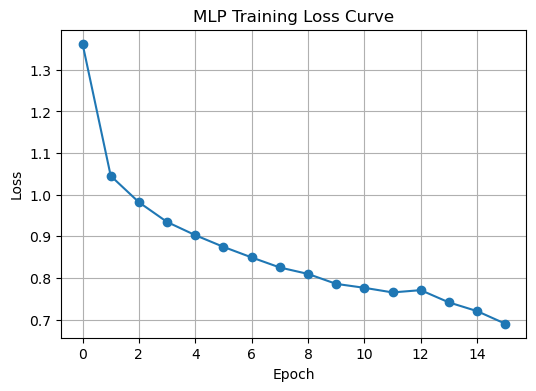

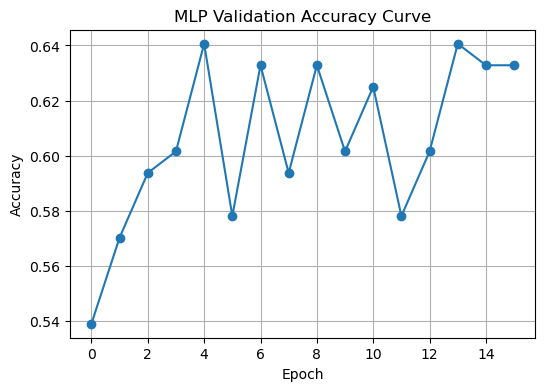

In [9]:
# Final Model Selection:
chosen_model = fine_grid_model

mlp = chosen_model

# 1. Plot training loss vs. epoch
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_, marker='o')
plt.title('MLP Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

if hasattr(mlp, 'validation_scores_'):
    plt.figure(figsize=(6,4))
    plt.plot(mlp.validation_scores_, marker='o')
    plt.title('MLP Validation Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


Interpretation:
- No crazy spikes in training loss, converges smoothly. Model is still learning until about epoch 4, then it's just tweaking weights for minor improvements.
- Validation accuracy oscilates around 0.62-0.64. This area represents the model's ceiling for gnerealization.
- Training loss still decreases past where validation accuracy plateaus and validation accuracy doesn'tcollapse. Means regularization and network size are in a good spot, and the model isn't overfitting or underfitting too badly.